# Doppler smearing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import scipy

import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [2]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

When a cosine signal is Doppler drifted, the frequency response smears out the signal power across frequency bins, as a function of the drift rate. For low drift rates, there isn't a significant change, but as signal covers multiple frequency bins per time bin, apparent signal power decreases accordingly. The data resolution can therefore be a strong factor in how much Doppler smearing occurs. 

To see this effect for "real", you can use `setigen.voltage` to simulate a drifting cosine signal at high drift rates. However, generating raw voltage data, even using a GPU, can be computationally expensive. In this notebook, we explore methods of simulating this effect directly in time-frequency space.

## Simulating the linear chirp frequency response

It turns out that the frequency response for a drifting signal can only be analytically expressed for a linear chirp. We follow the derivation here: https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp to write a custom `f_profile`:

In [3]:
def analytic_chirp(drift_rate, df, dt):
    """
    Analytic chirp spectrum, based on https://en.wikipedia.org/wiki/Chirp_spectrum#Linear_chirp.
    
    Deviations from derivation: we care about sample frequency, not angular
    frequency, so we make that conversion. Also, we need an intelligible
    "intensity" from which we can scale the signal, so we also change the
    scalar constant to be more consistent with signal injection.
    """
    T = dt 
    dF = drift_rate * T 
    dW = 2 * np.pi * dF
    const = np.pi * df / abs(dW)

    def f_profile(f, f_center):
        dw = 2 * np.pi * (f - f_center)
        X1 = (dw) / np.sqrt(np.pi * abs(dW) / T)
        X2 = (dW - dw) / np.sqrt(np.pi * abs(dW) / T)
        
        S1, C1 = scipy.special.fresnel(X1)
        S2, C2 = scipy.special.fresnel(X2)
        
        return const * ((C1 + C2)**2 + (S1 + S2)**2)
    return f_profile

There are some important deviations made to faciliate signal injection. Firstly, we care about sample frequency over angular frequency, so we have to be sure to stay in the correct units. Then, the constant in the expression for power doesn't give us useful values for intensity, so we additionally multiply by `frame.df / frame.dt` to get to the right units. Finally, we translate the frequency variable by `dOmega / 2` so that `f_start` is truly where our drifting signal starts.

One note about this is that generally in `setigen`, `f_start` in the path refers to the *center* of the signal at the starting time bin. In this case, the edge of the smeared frequency response will actually be at `f_start`, not the center. This frequency can be easily shifted by preference, but this better matches the result when simulating a drifting cosine signal with `setigen.voltage`. 

Trying this out in a synthetic frame:

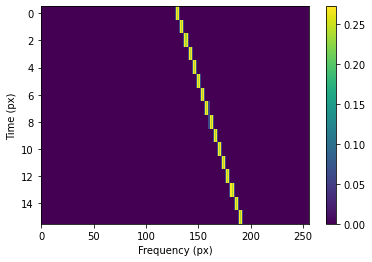

In [4]:
fr = stg.Frame.from_backend_params(256, 16)

drift_rate = 4 * fr.df / fr.dt
fr.add_signal(stg.constant_path(f_start=fr.get_frequency(128),
                                drift_rate=drift_rate),
              stg.constant_t_profile(level=1),
              analytic_chirp(drift_rate, fr.df, fr.dt),
              stg.constant_bp_profile(level=1))

fr.plot()

Looks good! Let's try a higher drift rate to see the detailed spectrum in adjacent time bins:

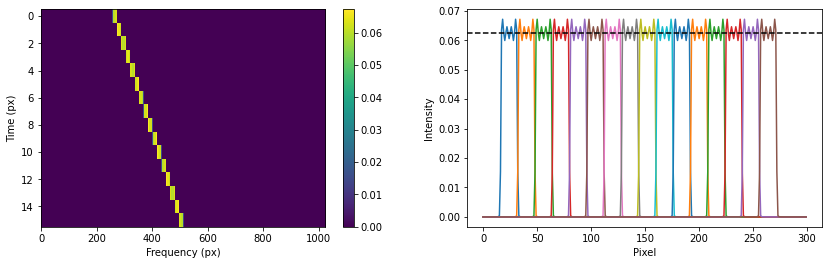

In [71]:
fr = stg.Frame.from_backend_params(1024, 16)

drift_rate = 16 * fr.df / fr.dt
fr.add_signal(stg.constant_path(f_start=fr.get_frequency(256),
                                drift_rate=drift_rate),
              stg.constant_t_profile(level=1),
              analytic_chirp(drift_rate, fr.df, fr.dt),
              stg.constant_bp_profile(level=1))

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
fr.plot()

# Zoom in on individual spectra
plt.subplot(1, 2, 2)
for i in range(16):
    plt.plot(fr.data[i][240:540])
# plt.plot(fr.data[1][240:600])
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.axhline(fr.df / fr.dt / drift_rate, ls='--', c='k')
plt.show()

We readily see the squiggles in the spectrum, and sharp drop-offs at the edges. As the signal goes to the next time bin, a similar spectra is repeated starting at the end of the previous one. 

Also, notice that the average intensity of these spectral responses essentially matches `(frame.df / frame.dt) / drift_rate`. In other words, the power is decimated by how much higher the signal drift rate is compared to the "unit drift rate" - the pixel over pixel drift rate implied by the frame resolution `df / dt`. This makes sense intuitively; if our signal crosses `n` frequency bins over one time step, the signal power should be spread equally in those `n` bins. 

However, this kind of reasoning only really works when the signal is actually drifting over multiple bins; i.e. `drift_rate / (frame.df / frame.dt) > 1`, and preferably much larger than 1. Otherwise, especially for very thin signals, we won't see much smearing in the first place. 

Another difficulty is that this analytic solution only works for linearly drifting, cosine signals. Intrinsically broader or more complex pathed signals can't really be simulated the same way, even though they would also exhibit Doppler smearing to some degree.